<a href="https://colab.research.google.com/github/JP12468/1/blob/main/CRmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

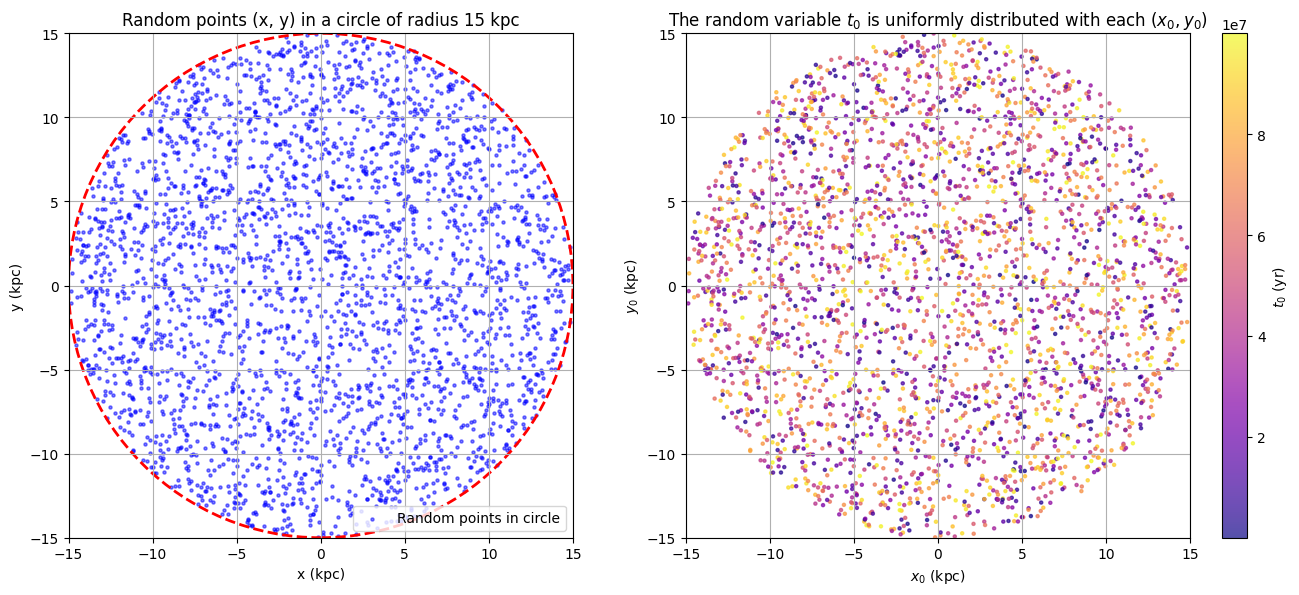

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit

# Constants
radius = 15
N_points = 3000

# Initialize the random number generator in JAX
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius 15 kpc
theta = random.uniform(key_theta, (N_points,), minval=0, maxval=2 * jnp.pi)
r = radius * jnp.sqrt(random.uniform(key_r, (N_points,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 uniformly in the interval (0, 10^8) years
t0 = random.uniform(key_t, (N_points,), minval=0, maxval=1e8)

# Plot the distribution of points (x0, y0) inside the circle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot (x0, y0)
axes[0].scatter(x0, y0, s=5, alpha=0.5, color='blue', label="Random points in circle")
circle = plt.Circle((0, 0), radius, color='red', fill=False, linestyle='dashed', linewidth=2)
axes[0].add_patch(circle)
axes[0].set_aspect('equal')
axes[0].set_xlim(-radius, radius)
axes[0].set_ylim(-radius, radius)
axes[0].set_xlabel("x (kpc)")
axes[0].set_ylabel("y (kpc)")
axes[0].set_title("Random points (x, y) in a circle of radius 15 kpc")
axes[0].legend()
axes[0].grid(True)

plt.tight_layout()

# Scatter plot colored by t0
sc = plt.scatter(x0, y0, c=t0, cmap='plasma', s=5, alpha=0.7)
circle = plt.Circle((0, 0), radius, color='red', fill=False, linestyle='dashed', linewidth=2)
plt.colorbar(sc, label=r'$t_0$ (yr)')
plt.xlabel('$x_0$ (kpc)')
plt.ylabel('$y_0$ (kpc)')
plt.title('The random variable $t_0$ is uniformly distributed with each $(x_0,y_0)$')
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()


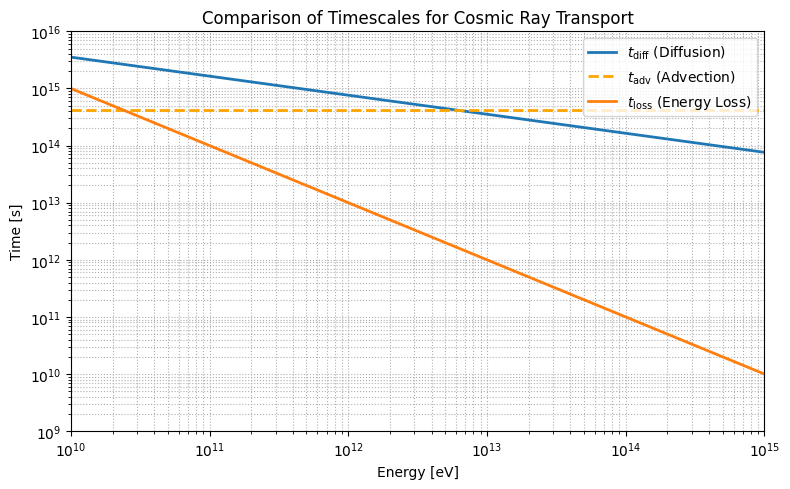

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 4 * 3.086e21  # 4 kpc in cm
V_wind = 3e7  # cm/s
b0 = 1e-16  # GeV^-1 s^-1
D0 = 1e28  # cm^2/s
delta = 1/3

# Energy range in eV and GeV
E_eV = np.logspace(10, 15, 5000)  # from 10^10 to 10^15 eV
E_GeV = E_eV * 1e-9

# Time scales
D_E = D0 * (E_GeV)**delta
t_diff = L**2 / (2 * D_E)
t_adv = L / V_wind
t_loss = 1 / (b0 * E_GeV)

# Plotting
plt.figure(figsize=(8, 5))
plt.loglog(E_eV, t_diff, label=r'$t_{\rm diff}$ (Diffusion)', lw=2)
plt.hlines(t_adv, E_eV.min(), E_eV.max(), colors='orange', linestyles='--', label=r'$t_{\rm adv}$ (Advection)', lw=2)
plt.loglog(E_eV, t_loss, label=r'$t_{\rm loss}$ (Energy Loss)', lw=2)

plt.xlabel('Energy [eV]')
plt.ylabel('Time [s]')
plt.xlim(1.0e10,1.0e15)
plt.ylim(1.0e9,1.0e16)
plt.title('Comparison of Timescales for Cosmic Ray Transport')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
kappa = 4.429 * 1e-6
Q_E = 4.175 * 1e30
t_max = L**2 / (2 * kappa)
N_sources = 1e4

# Initialize the random number generator in JAX
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius 15 kpc
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 in the interval (0, τ_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Spatial grid for plotting the map
x_grid = jnp.linspace(-R, R, 150)
y_grid = jnp.linspace(-R, R, 150)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# 3D Green's function
@jit
def G(t, x, y, x0, y0, t0, kappa_E):
    tau = t - t0
    tau = jnp.where(tau > 0, tau, 1e-6)

    n_values = jnp.arange(-10, 10)
    zn = 2 * n_values * L + (-1) ** n_values * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa_E * tau)

    psi_n = ((-1) ** n_values * Q_E / ((4 * jnp.pi * kappa_E * tau) ** (3 / 2))) * jnp.exp(exponent)
    return jnp.sum(psi_n)

# Vectorize G
G_vmap = jit(vmap(G, in_axes=(None, 0, 0, None, None, None, None), out_axes=0))

# Compute cosmic-ray density f_CR(x, y, z=0)
t_current = t_max
f_CR = jnp.zeros_like(x_mesh)

# Vectorize the entire computation
@jit
def compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current):
    def single_source_contribution(x, y, x0, y0, t0):
        return G_vmap(t_current, x, y, x0, y0, t0, kappa)

    f_CR_total = vmap(single_source_contribution, in_axes=(None, None, 0, 0, 0))(x_mesh.ravel(), y_mesh.ravel(), x0, y0, t0)
    return jnp.sum(f_CR_total, axis=0).reshape(x_mesh.shape)

f_CR = compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current)

# Plot the density map
plt.figure(figsize=(8, 6))
c = plt.contourf(x_grid, y_grid, f_CR, levels=100, cmap='inferno')
plt.colorbar(c, label='$f_{CR}(x,y,z=0)$')
plt.xlabel('$x$ (kpc)')
plt.ylabel('$y$ (kpc)')
plt.title('The map of cosmic-ray density $f_{CR}(x,y,z=0)$')
plt.show()


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (10000.0,).

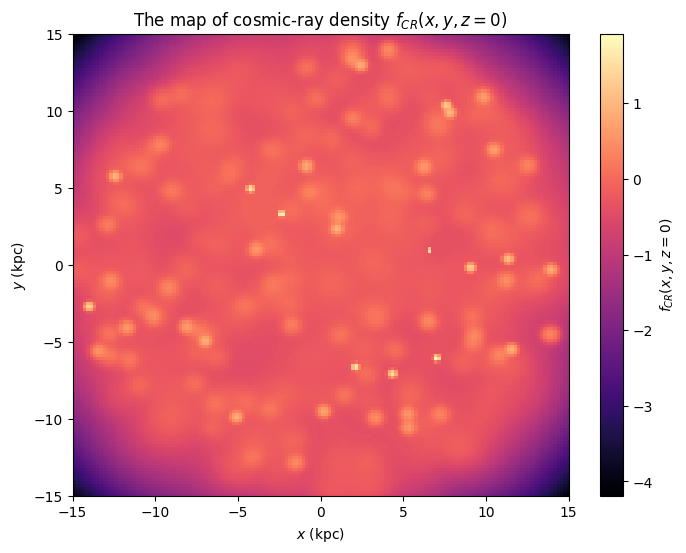

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit, device_put

# Constants
R = 15  # kpc
L = 4   # kpc
z0 = 0
kappa = 4.429 * 1e-5
Q_E = 1
# t_max = L**2 / (2*kappa)  # τ_max = L^2 / (2κ)
t_max = 5 * 10**4
N_sources = int(0.03 * t_max)  # Increase to 1 million sources

# Initialize random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample points (x0, y0) inside a circle of radius R
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample time t0 in the interval (0, τ_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Spatial grid
grid_size = 150
x_grid = jnp.linspace(-R, R, grid_size)
y_grid = jnp.linspace(-R, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Optimized 3D Green's function
@jit
def G(t, x, y, x0, y0, t0, kappa_E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-10, 11)  # Reduce number of n terms for speed
    zn = 2 * n_values * L + (-1) ** n_values * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa_E * tau)
    psi_n = ((-1) ** n_values * Q_E / ((4 * jnp.pi * kappa_E * tau) ** (3 / 2))) * jnp.exp(exponent)
    return jnp.sum(psi_n)

# Vectorize over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, 0, 0, None, None, None, None), out_axes=0))

# Compute cosmic-ray density f_CR
@jit
def compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current):
    def single_source_contribution(x, y, x0, y0, t0):
        return G_vmap(t_current, x, y, x0, y0, t0, kappa)

    # Batch processing over sources
    batch_size = 1000
    f_CR_total = jnp.zeros(x_mesh.ravel().shape)

    for i in range(0, len(x0), batch_size):
        f_CR_partial = vmap(single_source_contribution, in_axes=(None, None, 0, 0, 0))(
            x_mesh.ravel(), y_mesh.ravel(), x0[i:i+batch_size], y0[i:i+batch_size], t0[i:i+batch_size]
        )
        f_CR_total += jnp.sum(f_CR_partial, axis=0)

    return f_CR_total.reshape(x_mesh.shape)

# Put data on GPU
x_mesh, y_mesh = device_put((x_mesh, y_mesh))
x0, y0, t0 = device_put((x0, y0, t0))

# Compute f_CR on GPU
t_current = t_max
f_CR = compute_f_CR(x_mesh, y_mesh, x0, y0, t0, kappa, t_current)

plt.figure(figsize=(8, 6))

# Use imshow instead of contourf
plt.imshow(jnp.log10(jnp.nan_to_num(f_CR)).T, origin="lower", extent=[-15, 15, -15, 15], cmap='magma', aspect='auto')  # , vmin=30, vmax=34.5

# Add colorbar
plt.colorbar(label='$f_{CR}(x,y,z=0)$')

# Labels and title
plt.xlabel('$x$ (kpc)')
plt.ylabel('$y$ (kpc)')
plt.title('The map of cosmic-ray density $f_{CR}(x,y,z=0)$')

# Show plot
plt.show()


Cosmic Ray Density at Earth (x=8.5, y=0):
  E = 1.0e+13 eV : f_CR = 6.079e-30 eV$^-1$cm$^-3
  E = 1.0e+14 eV : f_CR = 1.876e-32 eV$^-1$cm$^-3
  E = 1.0e+15 eV : f_CR = 3.703e-35 eV$^-1$cm$^-3


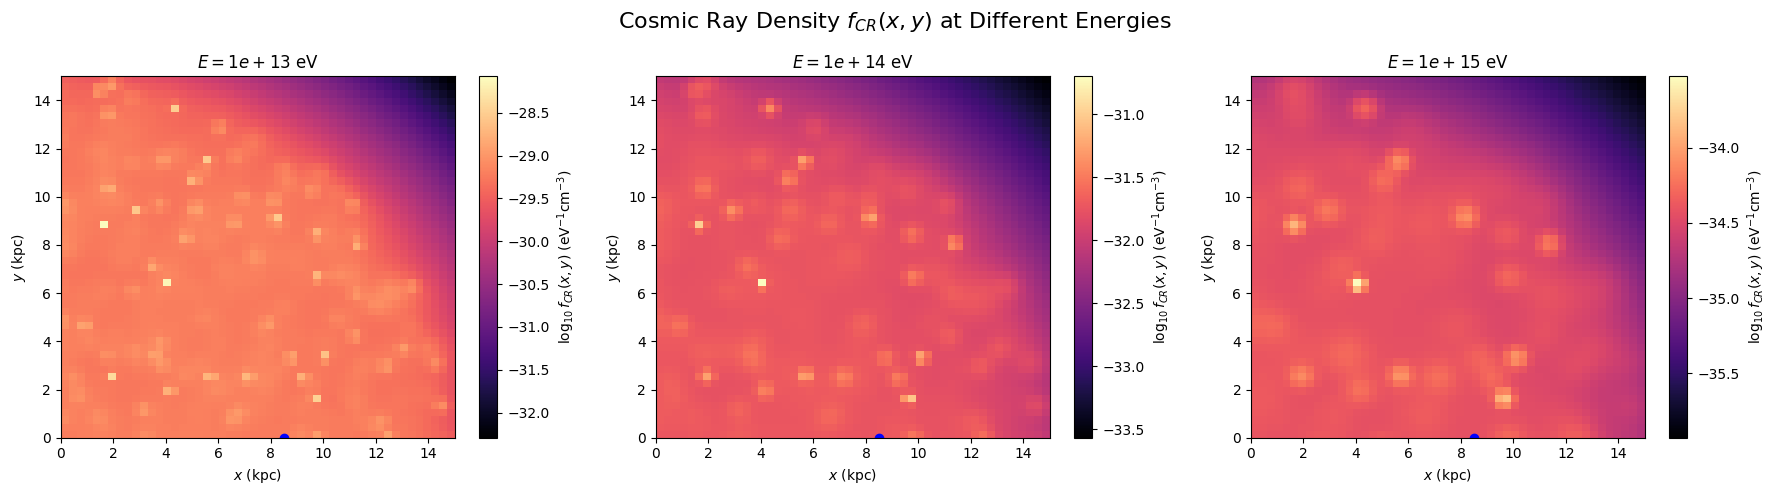

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit
from jax.scipy.ndimage import map_coordinates
import jax
jax.config.update("jax_enable_x64", True)

# Constants
R = 15.0  # kpc
L = 4.0   # kpc
z0 = 0.0
t_max = 1.0e6 # yr
N_sources = int(0.03 * t_max)  # Increased number of sources

# Random number generator
key = random.PRNGKey(0)
key_theta, key_r, key_t = random.split(key, 3)

# Sample (x0, y0) in a circular disk
theta = random.uniform(key_theta, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key_r, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)

# Sample t0 in (0, t_max)
t0 = random.uniform(key_t, (N_sources,), minval=0, maxval=t_max)

# Grid setup
grid_size = 50
x_grid = jnp.linspace(0.0, R, grid_size)
y_grid = jnp.linspace(0.0, R, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')

# Flatten mesh grids for vectorization
x_flat = x_mesh.ravel()
y_flat = y_mesh.ravel()

# Diffusion coefficient kappa(E)
def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr (diffusion coefficient constant)
    m_p_c2 = 0.938e9    # Proton rest energy in eV
    beta = 1.0  # Given in the problem


    # Calculate kappa(E) based on energy E in eV
    x = E / m_p_c2
    kappa_E = kappa_0 * beta * jnp.sqrt(jnp.sqrt(x**2 - 1))

    return kappa_E

# Adjust source spectrum Q(E)
def Q(E):
    alpha = 4.23 # The index of the source spectra
    xi_CR = 0.087  # Convert percentage to fraction
    E_SNR = 6.242e62  # in eV, from 10^51 erg
    m_p_c2 = 0.938e9  # Proton rest energy in eV
    Lambda = 4.111  # Normalization constant
    beta = 1.0  # Given in the problem

    x = E / m_p_c2
    Q_E = (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda * beta) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

    return Q_E

# Green's function G
@jit
def G(x, y, x0, y0, t0, t, E):
    tau = jnp.maximum(t - t0, 1e-6)  # Ensure tau > 0
    n_values = jnp.arange(-50, 51)
    zn = 2 * n_values[:, None] * L + (-1) ** n_values[:, None] * z0  # Shape (101, 1)

    # Compute exponent term with broadcasting
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa(E) * tau)
    psi_n = ((-1) ** n_values[:, None] * Q(E) / ((4 * jnp.pi * kappa(E) * 3.086e21 **2 * tau) ** (3 / 2))) * jnp.exp(exponent)

    return jnp.sum(psi_n, axis=0)  # Sum over n to collapse dimension

# Vectorized G over (x, y)
G_vmap = jit(vmap(G, in_axes=(None, None, 0, 0, 0, None, None), out_axes=0))

# Precompute G values efficiently
@jit
def precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E):
    f_CR_total = vmap(G, in_axes=(None, None, 0, 0, 0, None, None))(
        x_flat, y_flat, x0, y0, t0, t_current, E)
    return jnp.sum(f_CR_total, axis=0).reshape(grid_size, grid_size)

# JAX-compatible interpolation of G
def interpolate_G(x_mesh, y_mesh, x_grid, y_grid, f_CR):
    x_indices = (x_mesh - x_grid[0]) / (x_grid[-1] - x_grid[0]) * (grid_size - 1)
    y_indices = (y_mesh - y_grid[0]) / (y_grid[-1] - y_grid[0]) * (grid_size - 1)
    x_indices = jnp.clip(x_indices, 0, grid_size - 1)
    y_indices = jnp.clip(y_indices, 0, grid_size - 1)
    return map_coordinates(f_CR, [x_indices, y_indices], order=1)

# Compute precomputed G values
t_current = t_max
E_values = [1e13, 1e14, 1e15]
f_CR_list = []

for E in E_values:
    f_CR_E = precompute_G(x_flat, y_flat, x0, y0, t0, t_current, E)
    f_CR_list.append(f_CR_E)

# Earth's coordinates
x_earth = 8.5  # kpc
y_earth = 0.0  # kpc

# Find closest grid indices
ix = jnp.argmin(jnp.abs(x_grid - x_earth))
iy = jnp.argmin(jnp.abs(y_grid - y_earth))

# Print CR density at Earth
print("Cosmic Ray Density at Earth (x=8.5, y=0):")
for E, f_CR_E in zip(E_values, f_CR_list):
    f_val = f_CR_E[ix, iy]
    print(f"  E = {E:.1e} eV : f_CR = {f_val:.3e} eV$^{-1}$cm$^{-3}")

# Plot f_CR(x, y) maps for each energy
fig, axs = plt.subplots(1, len(E_values), figsize=(18, 5))
for i, (E, f_CR_E) in enumerate(zip(E_values, f_CR_list)):
    im = axs[i].imshow(
        jnp.log10(jnp.nan_to_num(f_CR_E)).T,
        origin="lower",
        extent=[x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]],
        cmap='magma',
        aspect='auto'
    )
    axs[i].plot(x_earth, y_earth, 'bo', label='Earth')
    axs[i].set_title(f'$E = {E:.0e}$ eV')
    axs[i].set_xlabel('$x$ (kpc)')
    axs[i].set_ylabel('$y$ (kpc)')
    fig.colorbar(im, ax=axs[i], label='$\log_{10} f_{CR}(x,y)$ (eV$^{-1}$cm$^{-3}$)')

plt.suptitle("Cosmic Ray Density $f_{CR}(x,y)$ at Different Energies", fontsize=16)
plt.tight_layout()
plt.show()

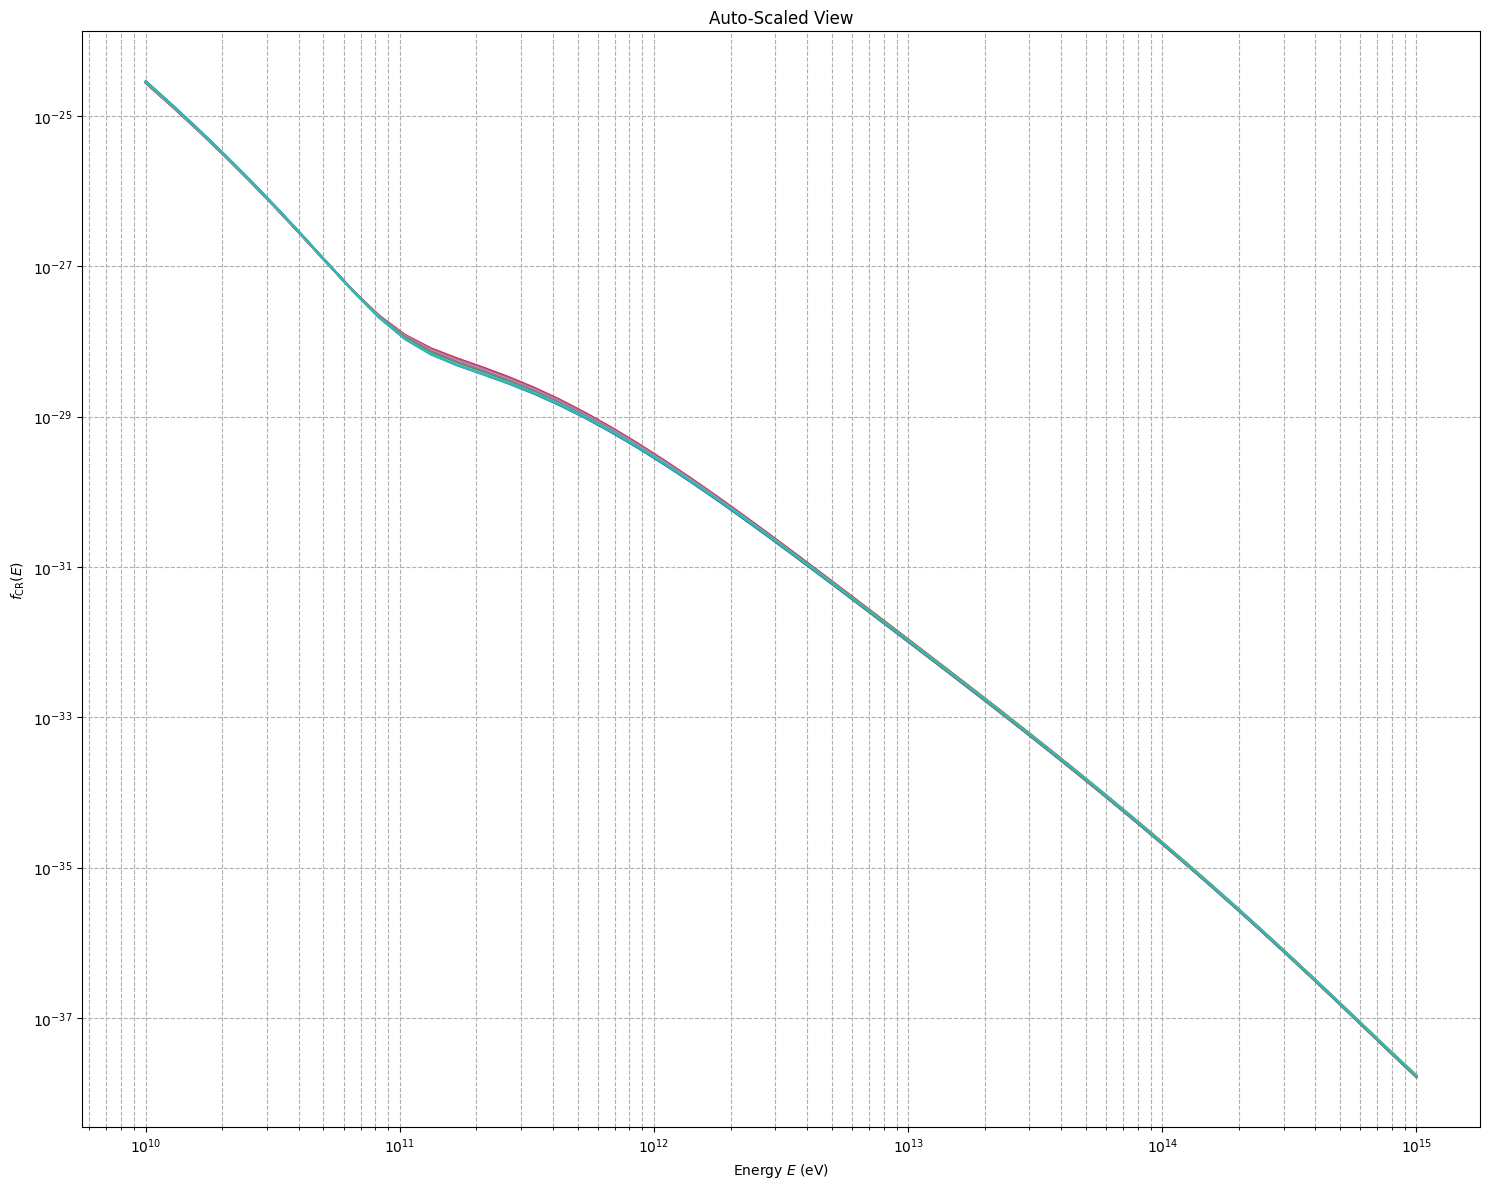

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit
from jax.scipy.ndimage import map_coordinates
import jax
jax.config.update("jax_enable_x64", True)

# ==== Constants and setup ====
R, L = 15.0, 4.0  # kpc
z0 = 0.0
t_max = 1e8  # years
N_sources = 3000
grid_size = 50
x_grid = jnp.linspace(6.0, 10.0, grid_size)
y_grid = jnp.linspace(-2.5, 2.5, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')
x_flat, y_flat = x_mesh.ravel(), y_mesh.ravel()

# ==== Random sources ====
key = random.PRNGKey(0)
theta = random.uniform(key, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)
t0 = random.uniform(key, (N_sources,), minval=0, maxval=t_max)

# ==== Physical functions ====
def kappa(E):
    kappa_0 = 3.3e-8
    m_p_c2 = 0.938e9
    return kappa_0 * jnp.sqrt(jnp.sqrt((E / m_p_c2) ** 2 - 1))

def Q(E):
    alpha, xi_CR, E_SNR = 4.23, 0.087, 6.242e62
    m_p_c2, Lambda = 0.938e9, 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

@jit
def G(x, y, x0, y0, t0, t, E):
    tau = jnp.maximum(t - t0, 1e-6)
    n = jnp.arange(-50, 51)
    zn = 2 * n[:, None] * L + (-1) ** n[:, None] * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa(E) * tau)
    psi_n = ((-1) ** n[:, None] * Q(E) / ((4 * jnp.pi * kappa(E) * 3.086e21**2 * tau) ** (3/2))) * jnp.exp(exponent)
    return jnp.sum(psi_n, axis=0)

@jit
def compute_f_CR_grid(E):
    G_vals = vmap(G, in_axes=(None, None, 0, 0, 0, None, None))(x_flat, y_flat, x0, y0, t0, t_max, E)
    return jnp.sum(G_vals, axis=0).reshape(grid_size, grid_size)

def interpolate_point(x, y, x_grid, y_grid, f_CR_grid):
    xi = (x - x_grid[0]) / (x_grid[-1] - x_grid[0]) * (grid_size - 1)
    yi = (y - y_grid[0]) / (y_grid[-1] - y_grid[0]) * (grid_size - 1)
    return map_coordinates(f_CR_grid, [[xi], [yi]], order=1)[0]

# ==== Precompute full f_CR(x, y) over energy range ====
E_range = jnp.logspace(10, 15, 50)
f_CR_grid_list = [compute_f_CR_grid(E) for E in E_range]

# ==== Generate 10 random test points around Earth ====
key_test = random.PRNGKey(42)
N_test = 10
theta_test = random.uniform(key_test, (N_test,), minval=0, maxval=2 * jnp.pi)
r_test = 0.2 * jnp.sqrt(random.uniform(key_test, (N_test,)))
x_test = 8.5 + r_test * jnp.cos(theta_test)
y_test = 0.0 + r_test * jnp.sin(theta_test)

# ==== Interpolate spectra at test points ====
spectra = []

for i in range(N_test):
    spectrum = [interpolate_point(x_test[i], y_test[i], x_grid, y_grid, f_grid) for f_grid in f_CR_grid_list]
    spectra.append(jnp.array(spectrum))

plt.figure(figsize=(15, 12))

for i in range(N_test):
    plt.plot(E_range, spectra[i], label=f'Point {i+1}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy $E$ (eV)')
plt.ylabel(r'$f_{\mathrm{CR}}(E)$')
plt.title('Auto-Scaled View')
plt.grid(True, which='both', ls='--')

plt.tight_layout()
plt.show()



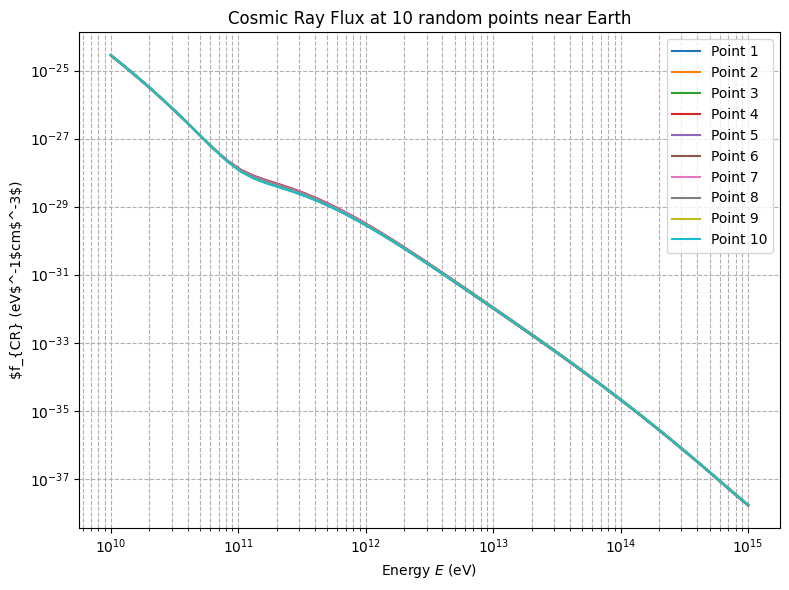

Estimated spectral index γ ≈ 3.21


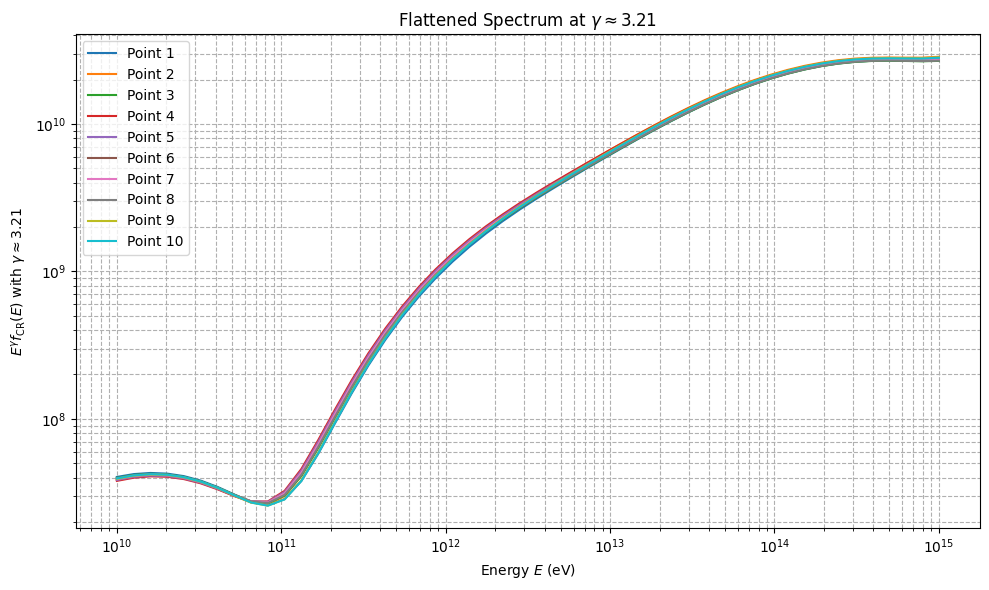

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from jax import vmap, jit
from jax.scipy.ndimage import map_coordinates
import jax
jax.config.update("jax_enable_x64", True)

# ==== Constants and setup ====
R, L = 15.0, 4.0  # kpc
z0 = 0.0
t_max = 1e8  # years
N_sources = 3000
grid_size = 50
x_grid = jnp.linspace(6.0, 10.0, grid_size)
y_grid = jnp.linspace(-2.5, 2.5, grid_size)
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing='ij')
x_flat, y_flat = x_mesh.ravel(), y_mesh.ravel()

# ==== Random sources ====
key = random.PRNGKey(0)
theta = random.uniform(key, (N_sources,), minval=0, maxval=2 * jnp.pi)
r = R * jnp.sqrt(random.uniform(key, (N_sources,)))
x0 = r * jnp.cos(theta)
y0 = r * jnp.sin(theta)
t0 = random.uniform(key, (N_sources,), minval=0, maxval=t_max)

# ==== Physical functions ====
def kappa(E):
    kappa_0 = 3.3e-8
    m_p_c2 = 0.938e9
    return kappa_0 * jnp.sqrt(jnp.sqrt((E / m_p_c2) ** 2 - 1))

def Q(E):
    alpha, xi_CR, E_SNR = 4.23, 0.087, 6.242e62
    m_p_c2, Lambda = 0.938e9, 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda) * (jnp.sqrt(x**2 - 1)) ** (2 - alpha)

@jit
def G(x, y, x0, y0, t0, t, E):
    tau = jnp.maximum(t - t0, 1e-6)
    n = jnp.arange(-50, 51)
    zn = 2 * n[:, None] * L + (-1) ** n[:, None] * z0
    exponent = -((x - x0) ** 2 + (y - y0) ** 2 + zn ** 2) / (4 * kappa(E) * tau)
    psi_n = ((-1) ** n[:, None] * Q(E) / ((4 * jnp.pi * kappa(E) * 3.086e21**2 * tau) ** (3/2))) * jnp.exp(exponent)
    return jnp.sum(psi_n, axis=0)

@jit
def compute_f_CR_grid(E):
    G_vals = vmap(G, in_axes=(None, None, 0, 0, 0, None, None))(x_flat, y_flat, x0, y0, t0, t_max, E)
    return jnp.sum(G_vals, axis=0).reshape(grid_size, grid_size)

def interpolate_point(x, y, x_grid, y_grid, f_CR_grid):
    xi = (x - x_grid[0]) / (x_grid[-1] - x_grid[0]) * (grid_size - 1)
    yi = (y - y_grid[0]) / (y_grid[-1] - y_grid[0]) * (grid_size - 1)
    return map_coordinates(f_CR_grid, [[xi], [yi]], order=1)[0]

# ==== Precompute full f_CR(x, y) over energy range ====
E_range = jnp.logspace(10, 15, 50)
f_CR_grid_list = [compute_f_CR_grid(E) for E in E_range]

# ==== Generate 10 random test points around Earth ====
key_test = random.PRNGKey(42)
N_test = 10
theta_test = random.uniform(key_test, (N_test,), minval=0, maxval=2 * jnp.pi)
r_test = 0.2 * jnp.sqrt(random.uniform(key_test, (N_test,)))
x_test = 8.5 + r_test * jnp.cos(theta_test)
y_test = 0.0 + r_test * jnp.sin(theta_test)

# ==== Interpolate spectra at test points ====
spectra = []
for i in range(N_test):
    spectrum = [interpolate_point(x_test[i], y_test[i], x_grid, y_grid, f_grid) for f_grid in f_CR_grid_list]
    spectra.append(jnp.array(spectrum))

# ==== Plot ====
plt.figure(figsize=(8, 6))
for i in range(N_test):
    plt.loglog(E_range, spectra[i], label=f'Point {i+1}')
plt.xlabel('Energy $E$ (eV)')
plt.ylabel(r'$f_{CR} (eV$^-1$cm$^-3$)')
plt.title('Cosmic Ray Flux at 10 random points near Earth')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

# ==== Estimate gamma and plot E^gamma * f_CR ====
from scipy.stats import linregress

# Fit log-log slope near 10^15 eV
log_E = jnp.log10(E_range)
log_f = jnp.log10(spectra[0])  # Use first point for fitting
mask = (log_E > 14.5) & (log_E < 15.2)
slope, intercept, *_ = linregress(log_E[mask], log_f[mask])
gamma_est = -slope
print(f"Estimated spectral index γ ≈ {gamma_est:.2f}")

# Plot E^gamma * f_CR to flatten the power law
plt.figure(figsize=(10, 6))
for i in range(N_test):
    adjusted_spectrum = (E_range ** gamma_est) * spectra[i]
    plt.plot(E_range, adjusted_spectrum, label=f'Point {i+1}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy $E$ (eV)')
plt.ylabel(rf'$E^{{\gamma}} f_{{\mathrm{{CR}}}}(E)$ with $\gamma \approx {gamma_est:.2f}$')
plt.title(rf'Flattened Spectrum at $\gamma \approx {gamma_est:.2f}$')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-3-8fe872e183f6>:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf /= np.trapz(pdf, R_vals)


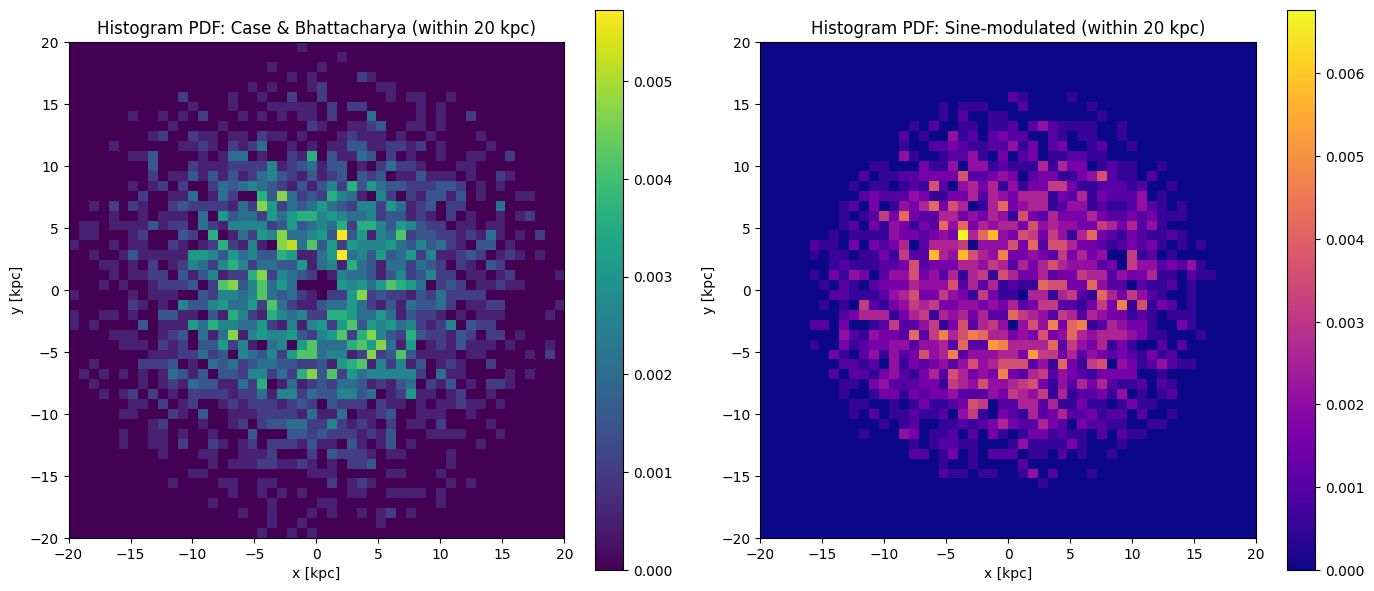

In [3]:
import numpy as np
import matplotlib.pyplot as plt

R_sun = 8.5
alpha = 2.0
beta_case = 3.53
R0 = 17.2
theta0 = 0.08
beta_sine = 0.13
A = 1.96
R_max = 20.0
N = 3000
bins = 50

def f_case(R):
    return (R / R_sun)**alpha * np.exp(-beta_case * (R - R_sun) / R_sun)

def f_sine(R):
    val = A * np.sin(np.pi * R / R0 + theta0) * np.exp(-beta_sine * R)
    return np.where(val > 0, val * 2 * np.pi * R, 0)

def sample_from_pdf(f, R_max, N):
    R_vals = np.linspace(0.01, R_max, 200)
    pdf = f(R_vals)
    pdf /= np.trapz(pdf, R_vals)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    u = np.random.rand(N)
    R_samples = np.interp(u, cdf, R_vals)
    theta = np.random.uniform(0, 2 * np.pi, N)
    x = R_samples * np.cos(theta)
    y = R_samples * np.sin(theta)
    return x, y

x_case, y_case = sample_from_pdf(lambda R: f_case(R) * 2 * np.pi * R, R_max, N)
x_sine, y_sine = sample_from_pdf(f_sine, R_max, N)

r_case = np.sqrt(x_case**2 + y_case**2)
r_sine = np.sqrt(x_sine**2 + y_sine**2)
x_case, y_case = x_case[r_case <= R_max], y_case[r_case <= R_max]
x_sine, y_sine = x_sine[r_sine <= R_max], y_sine[r_sine <= R_max]

hist_case, xedges, yedges = np.histogram2d(x_case, y_case, bins=bins, range=[[-R_max, R_max], [-R_max, R_max]])
hist_sine, _, _ = np.histogram2d(x_sine, y_sine, bins=bins, range=[[-R_max, R_max], [-R_max, R_max]])

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
pdf_case = hist_case / (np.sum(hist_case) * dx * dy)
pdf_sine = hist_sine / (np.sum(hist_sine) * dx * dy)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im0 = axs[0].imshow(pdf_case.T, origin='lower', extent=[-R_max, R_max, -R_max, R_max],
                    cmap='viridis', aspect='equal')
axs[0].set_title("Histogram PDF: Case & Bhattacharya (within 20 kpc)")
axs[0].set_xlabel("x [kpc]")
axs[0].set_ylabel("y [kpc]")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pdf_sine.T, origin='lower', extent=[-R_max, R_max, -R_max, R_max],
                    cmap='plasma', aspect='equal')
axs[1].set_title("Histogram PDF: Sine-modulated (within 20 kpc)")
axs[1].set_xlabel("x [kpc]")
axs[1].set_ylabel("y [kpc]")
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

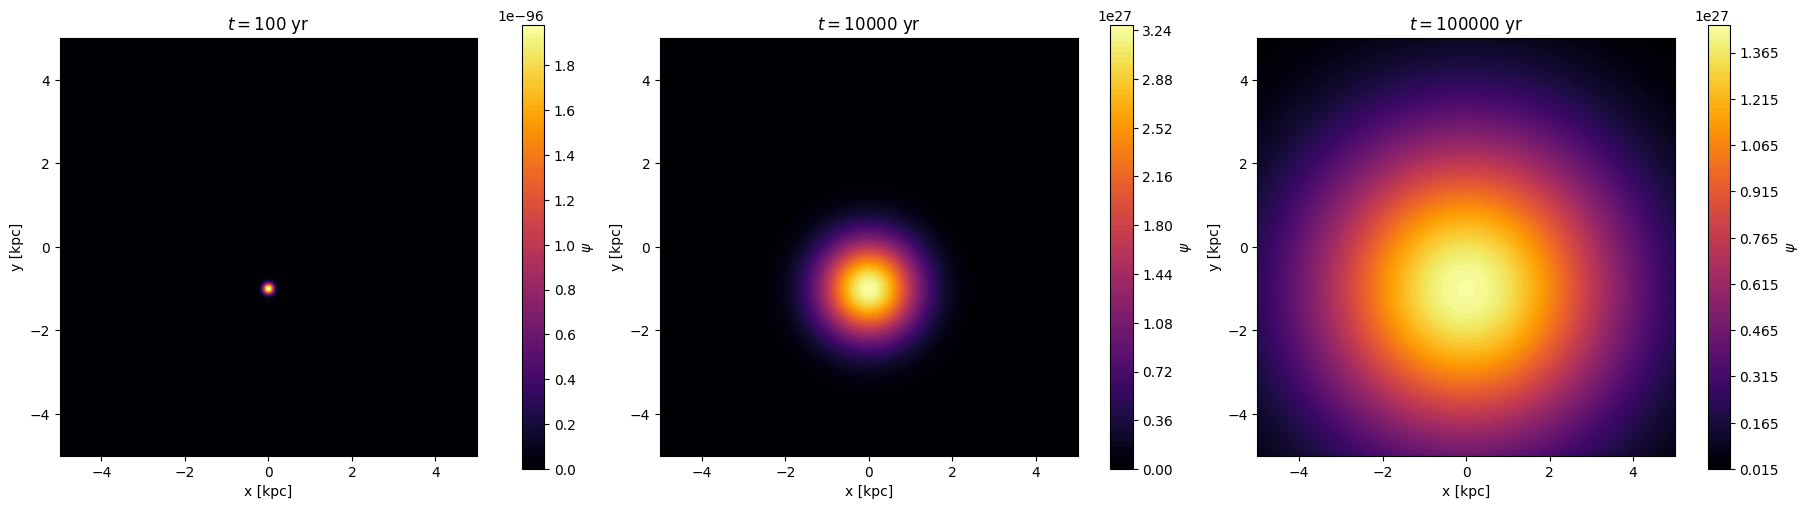

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x0, y0, z0 = 0.0, -1.0, 2.0
t0 = 0.0

E = 1e15  # eV
t_values = [1e4 * val for val in [0.01, 1.0, 10.0]]

def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr
    m_p_c2 = 0.938e9  # eV
    x = E / m_p_c2
    return kappa_0 * np.sqrt(np.sqrt(x**2 - 1))

def Q(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62  # eV
    m_p_c2 = 0.938e9
    Lambda = 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda) * (np.sqrt(x**2 - 1)) ** (2 - alpha)

def psi(E, x, y, t):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0
    r2 = (x - x0)**2 + (y - y0)**2 + (0 - z0)**2  # mặt phẳng z = 0
    norm = (4 * np.pi * D * tau) ** (3/2)
    return Q(E) / norm * np.exp(-r2 / (4 * D * tau))

x_vals = np.linspace(-5, 5, 200)
y_vals = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x_vals, y_vals)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for idx, t in enumerate(t_values):
    Z = np.array([[psi(E, x, y, t) for x in x_vals] for y in y_vals])
    ax = axes[idx]
    c = ax.contourf(X, Y, Z, levels=100, cmap='inferno')
    ax.set_title(fr'$t={t:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_aspect('equal')
    fig.colorbar(c, ax=ax, label=r'$\psi$')

plt.show()


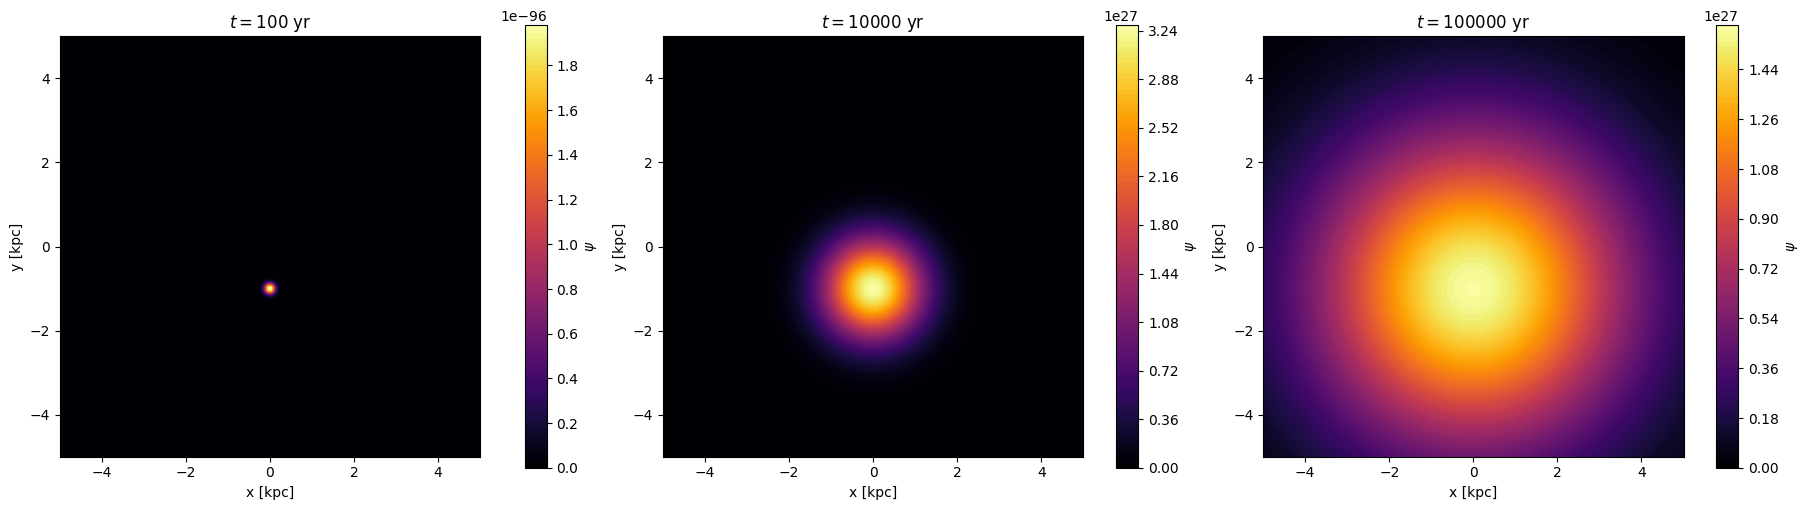

In [1]:
import numpy as np
import matplotlib.pyplot as plt


x0, y0, z0 = 0.0, -1.0, 2.0
t0 = 0.0
L = 4.0
N_images = 30

E = 1e15  # eV
t_values = [1e4 * val for val in [0.01, 1.0, 10.0]]

def kappa(E):
    kappa_0 = 3.3e-8  # kpc^2 / yr
    m_p_c2 = 0.938e9  # eV
    x = E / m_p_c2
    return kappa_0 * np.sqrt(np.sqrt(x**2 - 1))

def Q(E):
    alpha = 4.23
    xi_CR = 0.087
    E_SNR = 6.242e62  # eV
    m_p_c2 = 0.938e9
    Lambda = 4.111
    x = E / m_p_c2
    return (xi_CR * E_SNR) / ((m_p_c2) ** 2 * Lambda) * (np.sqrt(x**2 - 1)) ** (2 - alpha)

def psi_with_images(E, x, y, t, z=0.0):
    D = kappa(E)
    tau = t - t0
    if tau <= 0:
        return 0.0

    norm = (4 * np.pi * D * tau) ** (3/2)
    sum_image = 0.0
    for n in range(-N_images, N_images + 1):
        z_image = (-1)**n * z0 + 2 * L * n
        r2 = (x - x0)**2 + (y - y0)**2 + (z - z_image)**2
        sum_image += np.exp(-r2 / (4 * D * tau))

    return Q(E) / norm * sum_image

x_vals = np.linspace(-5, 5, 200)
y_vals = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x_vals, y_vals)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

for idx, t in enumerate(t_values):
    Z = np.array([[psi_with_images(E, x, y, t) for x in x_vals] for y in y_vals])
    ax = axes[idx]
    c = ax.contourf(X, Y, Z, levels=100, cmap='inferno')
    ax.set_title(fr'$t={t:.0f}$ yr')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_aspect('equal')
    fig.colorbar(c, ax=ax, label=r'$\psi$')

plt.show()
